# HAWC analysis with Gammapy

This tutorial uses Gammapy 1.2

In [1]:
import matplotlib.pyplot as plt
from gammapy.data import DataStore, HDUIndexTable, ObservationTable
from gammapy.datasets import MapDataset, Datasets
from gammapy.makers import MapDatasetMaker,SafeMaskMaker, FoVBackgroundMaker
import numpy as np
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
import astropy.units as u
from regions import CircleSkyRegion
from gammapy.modeling.models import  FoVBackgroundModel, PowerLawNormSpectralModel


# Step 1: data reduction

The events and instrument response functions provided are run through the `MapDatasetMaker` in the data reduction step. You can choose which energy estimator (NN or GP) with the variable "which".


In [25]:
# which energy estimator
which="NN"
#which="GP"

# paths and file names
data_path = "./"
hdu_filename = 'hdu-index-table-' + which + "-Crab.fits.gz"
obs_filename = 'obs-index-table-' + which + "-Crab.fits.gz"

# there is only one observation table so we can read it now
obs_table = ObservationTable.read(data_path+obs_filename)


# create the map dataset maker
maker = MapDatasetMaker(selection = ["counts", "background", "exposure", "edisp", "psf"])
safemask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

# create the energy reco axis
energy_axis = MapAxis.from_edges(
        [1.00,1.78,3.16,5.62,10.0,17.8,31.6,56.2,100,177,316] * u.TeV,

        name="energy",
        interp="log"
    )

# and energy true axis
energy_axis_true = MapAxis.from_energy_bounds(1e-3, 1e4, nbin=140, unit="TeV", name="energy_true")


# create a geometry around the Crab location
geom = WcsGeom.create(skydir=SkyCoord(ra=83.63,dec=22.01, unit='deg', frame="icrs"),
                     width=6*u.deg,
                     axes=[energy_axis],
                     binsz=0.05)

circle = CircleSkyRegion(center=geom.center_skydir, radius=1 * u.deg)
exclusion_mask = geom.region_mask([circle], inside=False)

fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)


# initiate empty datasets object
datasets = Datasets()

event_types = np.arange(1,10)

for idx, bin_id in enumerate(event_types): #loop over nhit bins
    
    # load the hdu index table for this event type
    hdu_table = HDUIndexTable.read(data_path+hdu_filename, hdu=bin_id)
    hdu_table[-1]['HDU_CLASS'] = "psf_map_reco"
    # make the DataStore
    data_store = DataStore( hdu_table=hdu_table, obs_table=obs_table)

    # get the observation for this datastore
    observations = data_store.get_observations()
    print(len(observations))
    # create empty dataset that will contain the data
    dataset_empty = MapDataset.create(geom=geom, name="nHit-" + str(bin_id),
                                      energy_axis_true=energy_axis_true,
                                      reco_psf=True,
                                      binsz_irf = 1*u.deg,
                                      rad_axis = MapAxis.from_bounds(0,3,200, unit='deg',name='rad'))

    # run the maker
    dataset = maker.run(dataset_empty, observations[0])
    dataset.exposure.meta["livetime"] = "1 s"
    dataset = safemask_maker.run(dataset)

    # we need to correct the background and exposure by number of transits
    transit_map = Map.read('irfs/TransitsMap_Crab.fits.gz')
    transit_number = transit_map.get_by_coord(geom.center_skydir)
    #transit_number = transit_map.interp_to_geom(geom.to_image()).data[np.newaxis, :,:]
    dataset.background.data*=transit_number
    dataset.exposure.data*=transit_number


    datasets.append(dataset)


1
1
1
1
1
1
1
1
1


In [45]:
datasets.write('HAWC_pass4_public_Crab.yaml', overwrite=True)

# Step 2: Checks of the data reduction

We will produce significance maps to make sure that everything worked as it should

In [27]:
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, GaussianSpatialModel,PointSpatialModel, PowerLawSpectralModel
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,ExcessMapEstimator
)
from gammapy.modeling.models import Models

In [28]:
e = ExcessMapEstimator(correlation_radius='0.2 deg', selection_optional = [], energy_edges=energy_axis.edges)
excess_with_source = []
for d in datasets:
    excess_with_source.append(e.run(d))

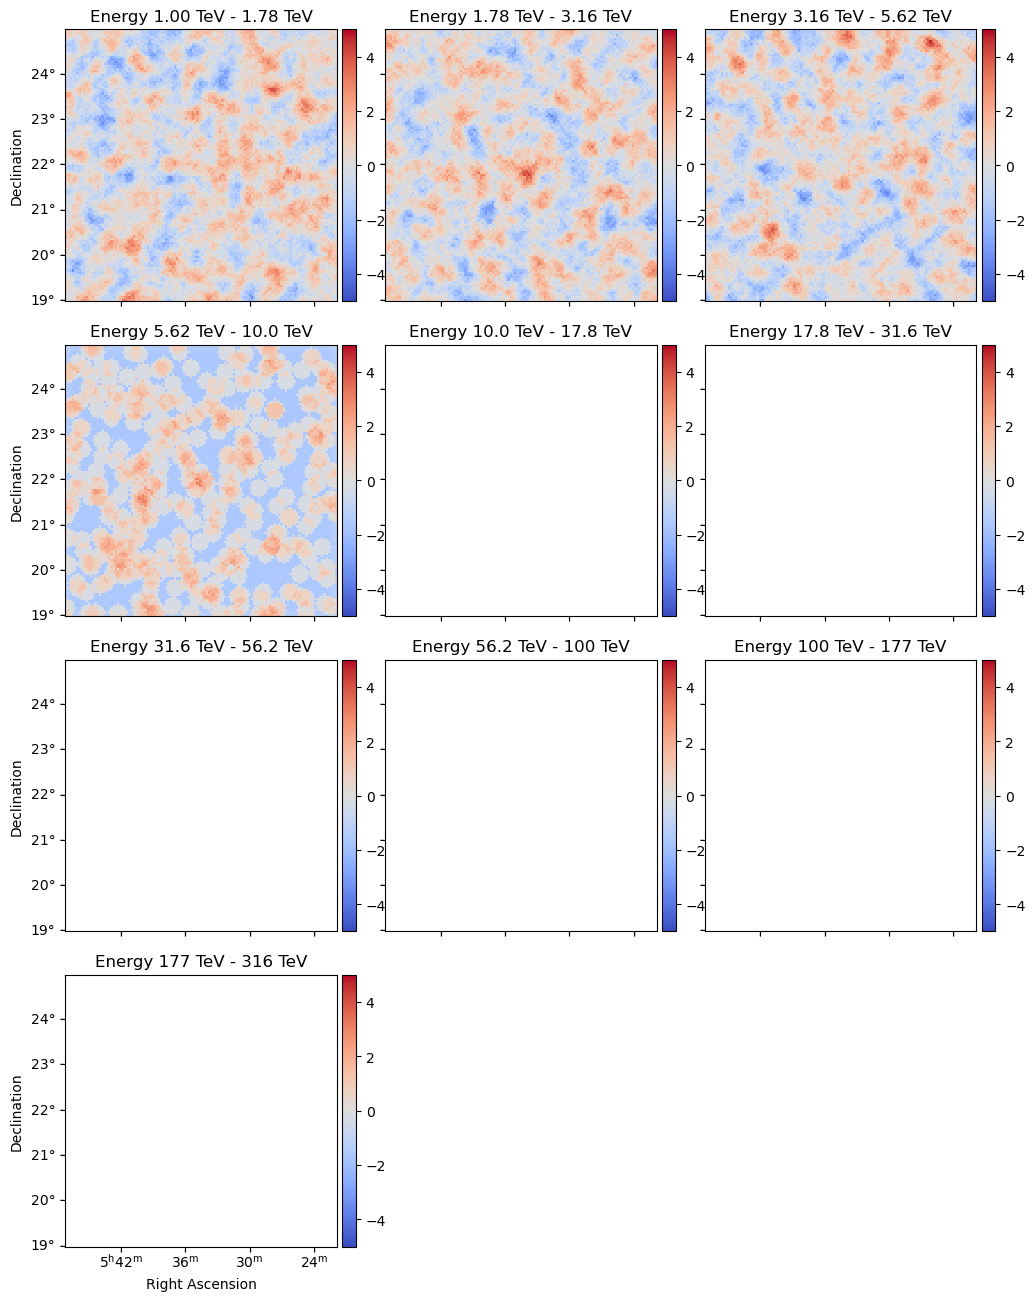

In [29]:
(datasets[0].mask*excess_with_source[0]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

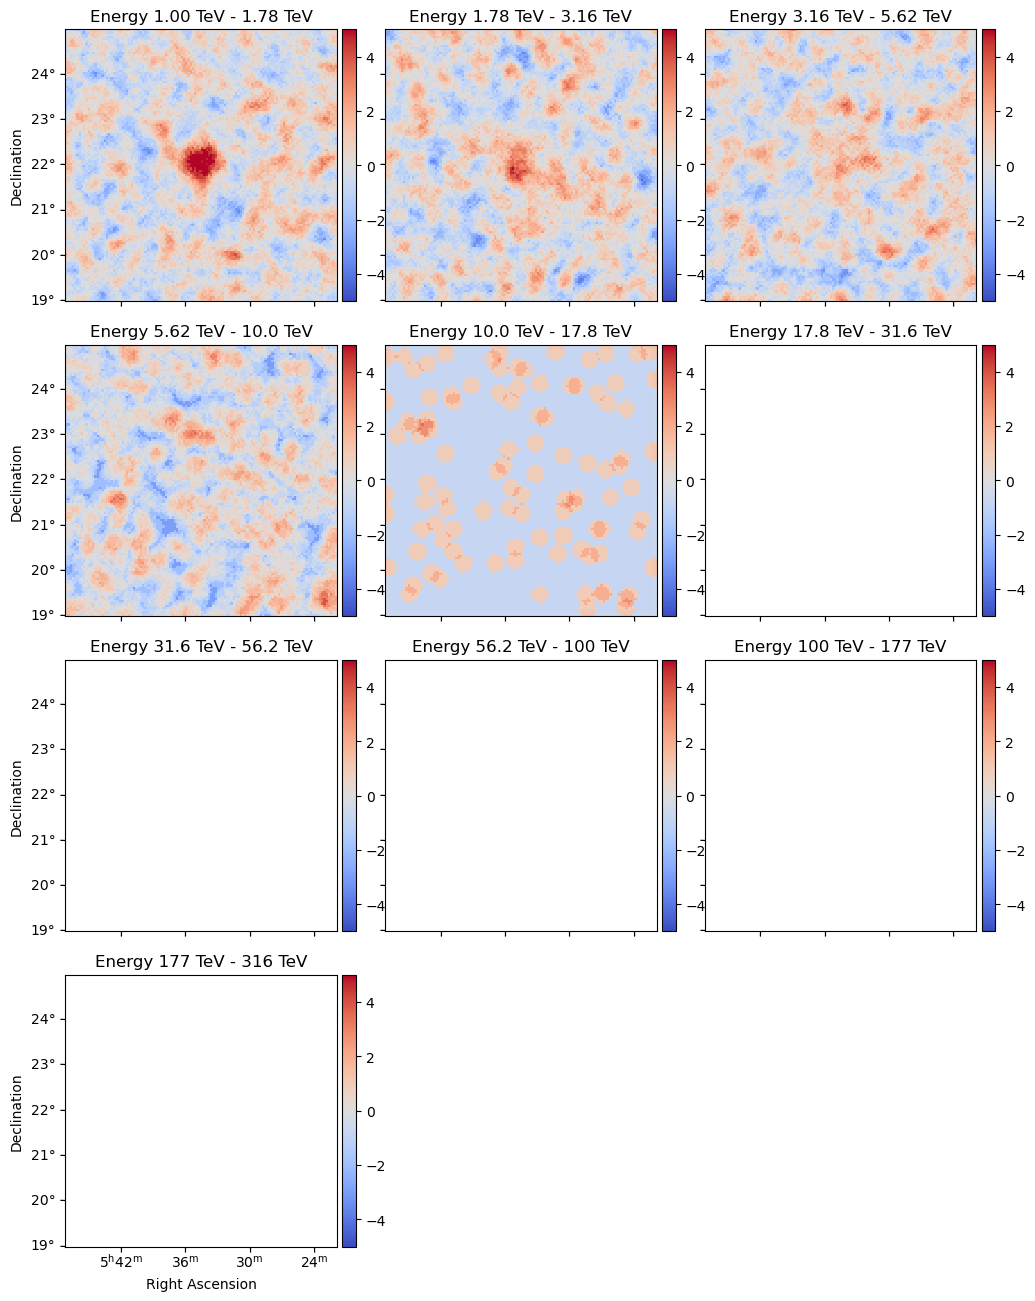

In [30]:
(datasets[2].mask*excess_with_source[2]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

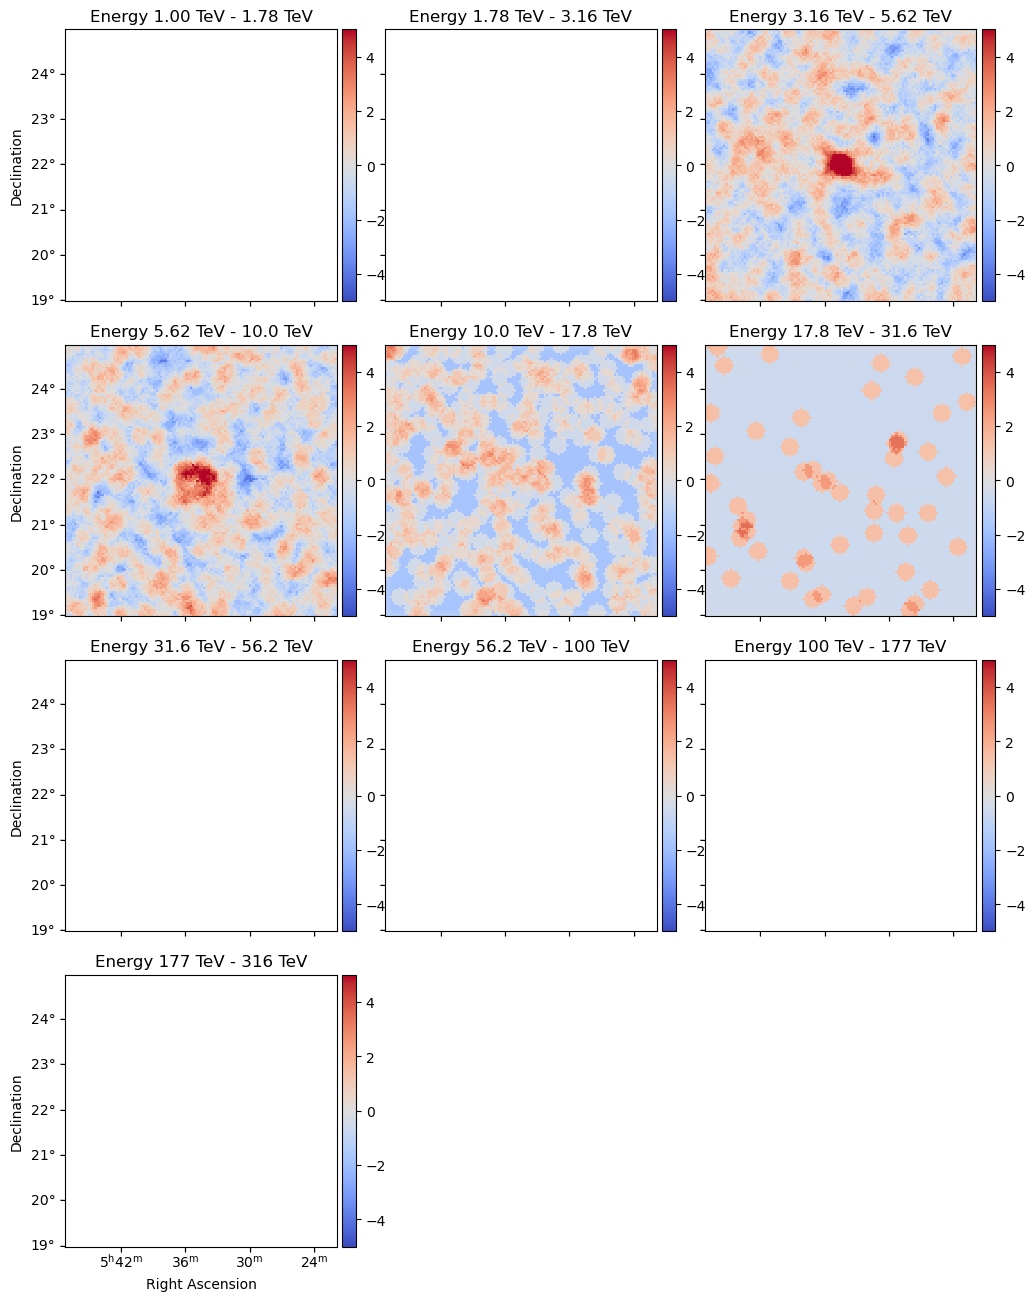

In [31]:
(datasets[4].mask*excess_with_source[4]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

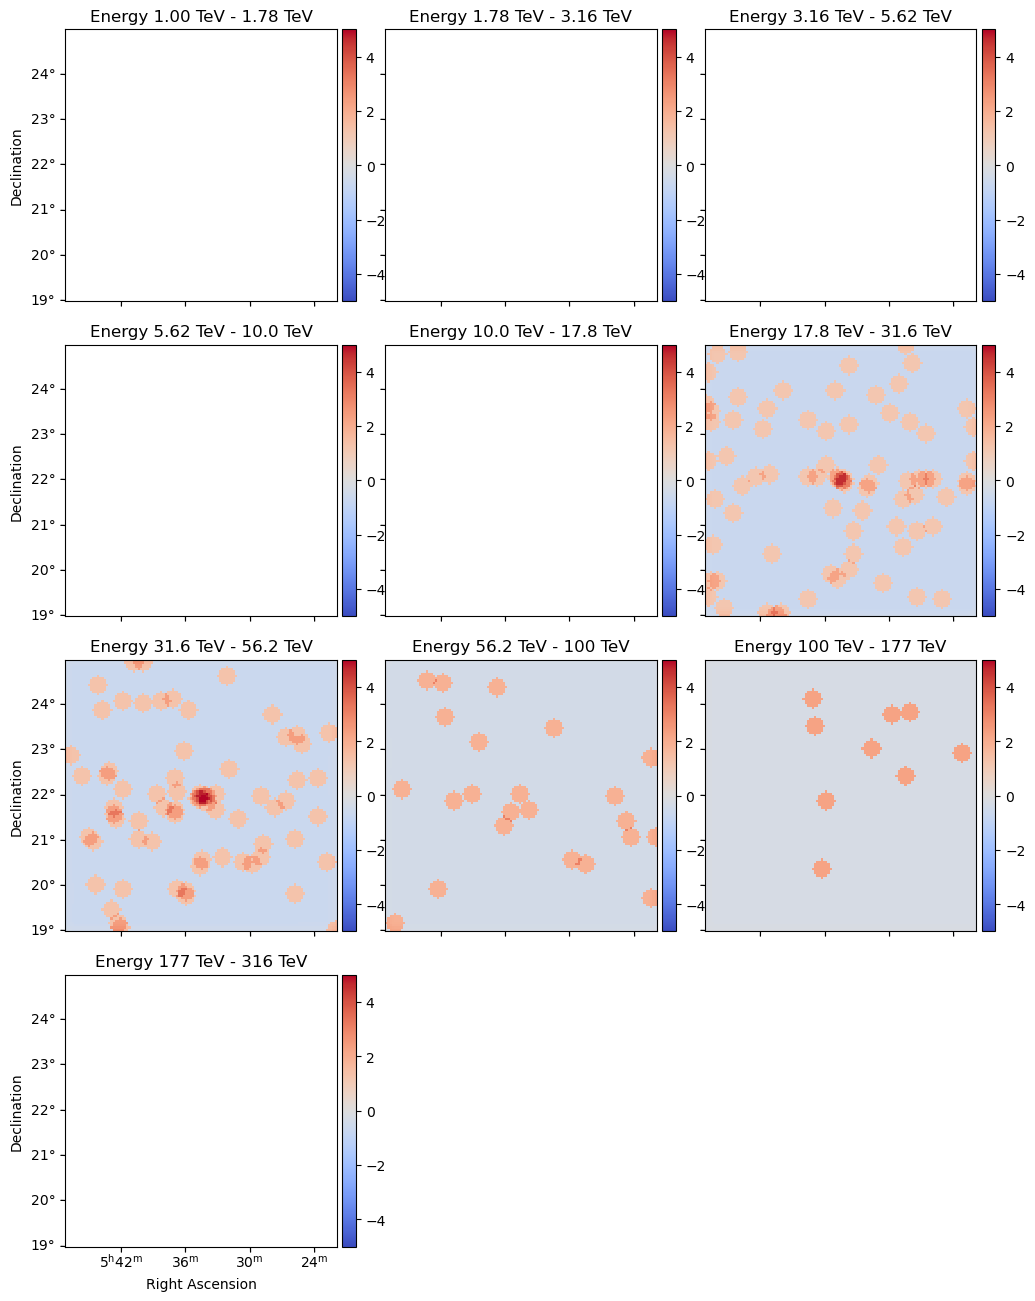

In [32]:
(datasets[8].mask*excess_with_source[8]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

# Step 3: fitting a model

Finally, we fit a spatial and spectral model. The spatial component is a point source, whereas the spectral one is described by a LogParabola


In [33]:
from astropy.coordinates import SkyCoord
position = SkyCoord(ra="83.63 deg", dec="22.01deg")

In [34]:
spatial_model = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spatial_model.lon_0.min = 80
spatial_model.lon_0.max = 89
spatial_model.lat_0.max = 25
spatial_model.lat_0.min = 19
spatial_model.lon_0.frozen = False
spatial_model.lat_0.frozen = False

spectral_model = LogParabolaSpectralModel(
        amplitude="2e-13 TeV-1 cm-2 s-1",
        alpha=2.7,
        beta=0.1,
        reference="7 TeV"
)


spectral_model.amplitude.error = "0.1e-13 TeV-1 cm-2 s-1"
spectral_model.beta.error = 0.1
spectral_model.alpha.error = 0.1


model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='crab model')
#model.apply_irf["psf_after_edisp"]=True

In [35]:

datasets.models = [model]

In [36]:
d.models[0].parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,2.0000e-13,TeV-1 s-1 cm-2,1.000e-14,nan,nan,False,True,,
,reference,7.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.7000e+00,,1.000e-01,nan,nan,False,False,,
,beta,1.0000e-01,,1.000e-01,nan,nan,False,False,,
,lon_0,8.3630e+01,deg,0.000e+00,8.000e+01,8.900e+01,False,False,,
,lat_0,2.2010e+01,deg,0.000e+00,1.900e+01,2.500e+01,False,False,,


In [37]:
for d in datasets:
    print('new dataset')
    for m in d.models:
        print(m.parameters.to_table())

new dataset
type    name     value         unit        error      min       max    frozen is_norm link prior
---- --------- ---------- -------------- --------- --------- --------- ------ ------- ---- -----
     amplitude 2.0000e-13 TeV-1 s-1 cm-2 1.000e-14       nan       nan  False    True           
     reference 7.0000e+00            TeV 0.000e+00       nan       nan   True   False           
         alpha 2.7000e+00                1.000e-01       nan       nan  False   False           
          beta 1.0000e-01                1.000e-01       nan       nan  False   False           
         lon_0 8.3630e+01            deg 0.000e+00 8.000e+01 8.900e+01  False   False           
         lat_0 2.2010e+01            deg 0.000e+00 1.900e+01 2.500e+01  False   False           
new dataset
type    name     value         unit        error      min       max    frozen is_norm link prior
---- --------- ---------- -------------- --------- --------- --------- ------ ------- ---- -----
     a

In [38]:
minuit_opts = {"strategy": 1}

#define the fitter
fit = Fit(store_trace=True
            )
fit.backend = "minuit"
fit.optimize_opts = minuit_opts

In [39]:
%%time
result = fit.run(datasets)

CPU times: user 1min 13s, sys: 108 ms, total: 1min 13s
Wall time: 1min 13s


In [40]:
model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,2.2500e-13,TeV-1 s-1 cm-2,1.529e-14,nan,nan,False,True,,
,reference,7.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.6661e+00,,6.285e-02,nan,nan,False,False,,
,beta,6.3840e-02,,3.870e-02,nan,nan,False,False,,
,lon_0,8.3633e+01,deg,8.579e-03,8.000e+01,8.900e+01,False,False,,
,lat_0,2.2014e+01,deg,8.079e-03,1.900e+01,2.500e+01,False,False,,


In [16]:
model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,amplitude,2.2667e-13,cm-2 s-1 TeV-1,1.528e-14,nan,nan,False,
spectral,reference,7.0000e+00,TeV,0.000e+00,nan,nan,True,
spectral,alpha,2.6540e+00,,6.397e-02,nan,nan,False,
spectral,beta,8.2916e-02,,3.945e-02,nan,nan,False,
spatial,lon_0,8.3632e+01,deg,8.554e-03,8.000e+01,8.900e+01,False,
spatial,lat_0,2.2013e+01,deg,8.058e-03,1.900e+01,2.500e+01,False,


### Check that the fit worked by looking at the likelihood profiles

In [41]:
total_stat = result.total_stat

for par in model.parameters:
    if par.frozen is False:
        profile = fit.stat_profile(datasets, parameter=par)

        plt.plot(
            profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat
        )
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.ylim(-0.1,5)
        plt.show()
        plt.close()

KeyError: 'amplitude_scan'

### Compare with published reference

In [42]:
#https://arxiv.org/pdf/1909.08609.pdf
if which=="GP":
    ref_spectral_model = LogParabolaSpectralModel(
        amplitude="2.35e-13 TeV-1 cm-2 s-1",
        alpha=2.79,
        beta=0.10,
        reference="7 TeV"
    )
    ref_spectral_model.amplitude.error = "0.04e-13 TeV-1 cm-2 s-1"
    ref_spectral_model.beta.error = 0.02
    ref_spectral_model.alpha.error = 0.01

else:
    ref_spectral_model = LogParabolaSpectralModel(
        amplitude="2.31e-13 TeV-1 cm-2 s-1",
        alpha=2.73,
        beta=0.06,
        reference="7 TeV"
    )
    ref_spectral_model.amplitude.error = "0.02e-13 TeV-1 cm-2 s-1"
    ref_spectral_model.beta.error = 0.02
    ref_spectral_model.alpha.error = 0.01

ref_model = SkyModel( spectral_model=ref_spectral_model,spatial_model=spatial_model,  name='reference')
#ref_model.apply_irf["psf_after_edisp"]=True

In [43]:
ref_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,2.3100e-13,TeV-1 s-1 cm-2,2.000e-15,nan,nan,False,True,,
,reference,7.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.7300e+00,,1.000e-02,nan,nan,False,False,,
,beta,6.0000e-02,,2.000e-02,nan,nan,False,False,,
,lon_0,8.3633e+01,deg,8.579e-03,8.000e+01,8.900e+01,False,False,,
,lat_0,2.2014e+01,deg,8.079e-03,1.900e+01,2.500e+01,False,False,,


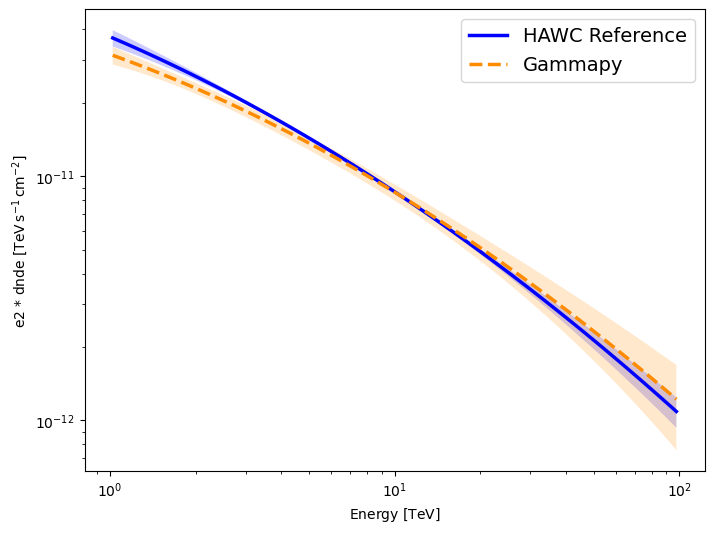

In [44]:
plt.figure(figsize=(8,6))
ax = ref_spectral_model.plot(energy_bounds=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference", color='blue', lw=2.5)
ref_spectral_model.plot_error(energy_bounds=(1, 100) * u.TeV, energy_power=2, ax=ax, facecolor=ax.lines[-1].get_color())
spectral_model.plot(ax=ax, energy_bounds=(1, 100) * u.TeV, energy_power=2, label="Gammapy", color='darkorange', linestyle='--', lw=2.5)
spectral_model.plot_error(ax=ax, energy_bounds=(1, 100) * u.TeV, energy_power=2, facecolor=ax.lines[-1].get_color())

plt.legend(fontsize=14)
plt.show()

### Make significance maps again but this time subtracting the best-fit model to check the agreement

In [21]:
excess = []
for d in datasets:
    excess.append(e.run(d))

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


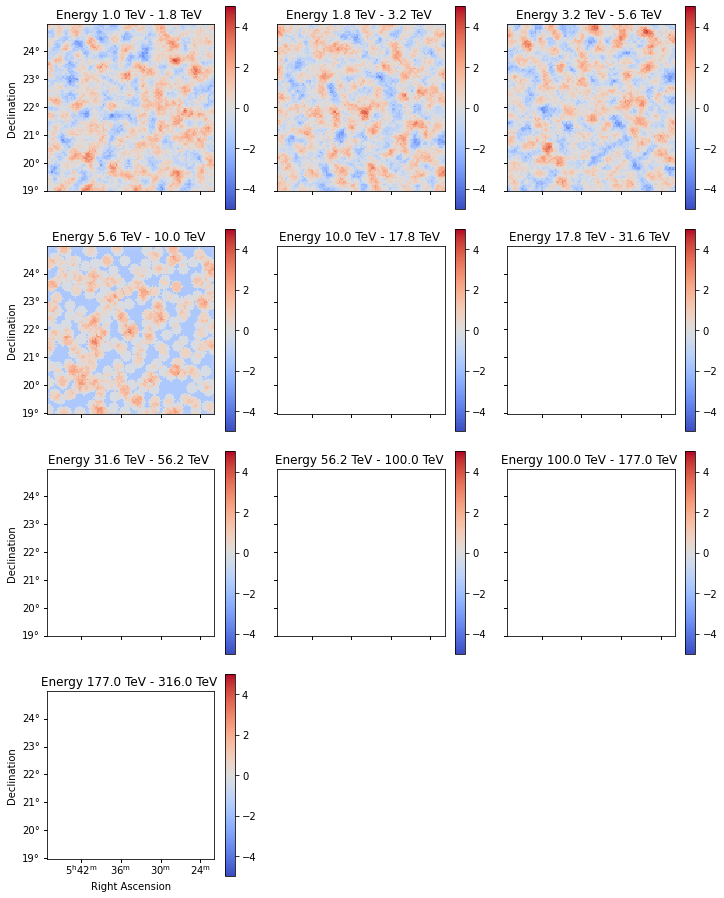

In [22]:
(datasets[0].mask*excess[0]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


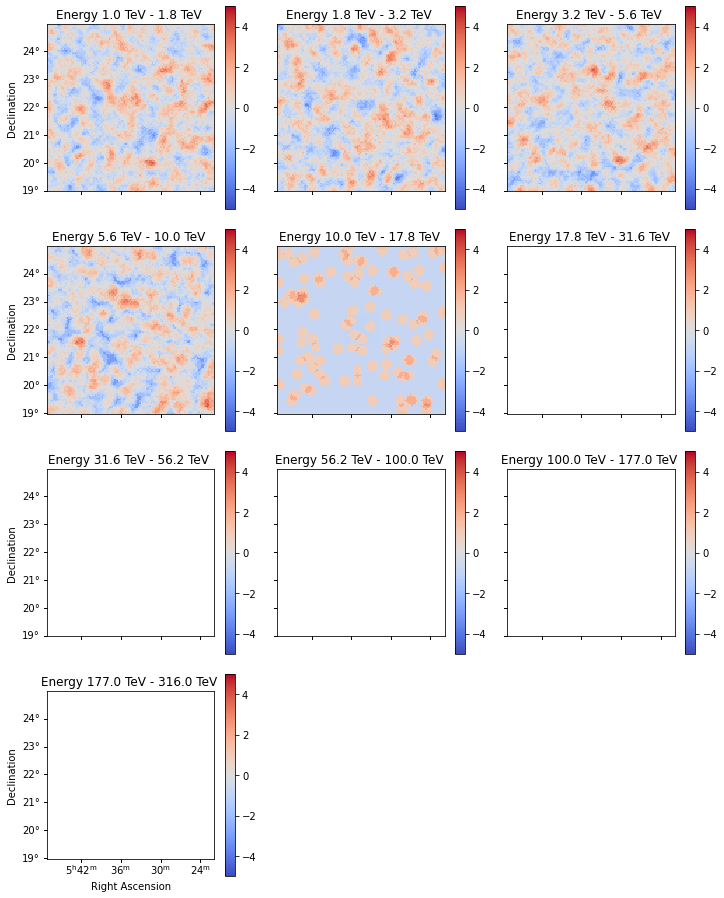

In [23]:
(datasets[2].mask_safe*excess[2]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


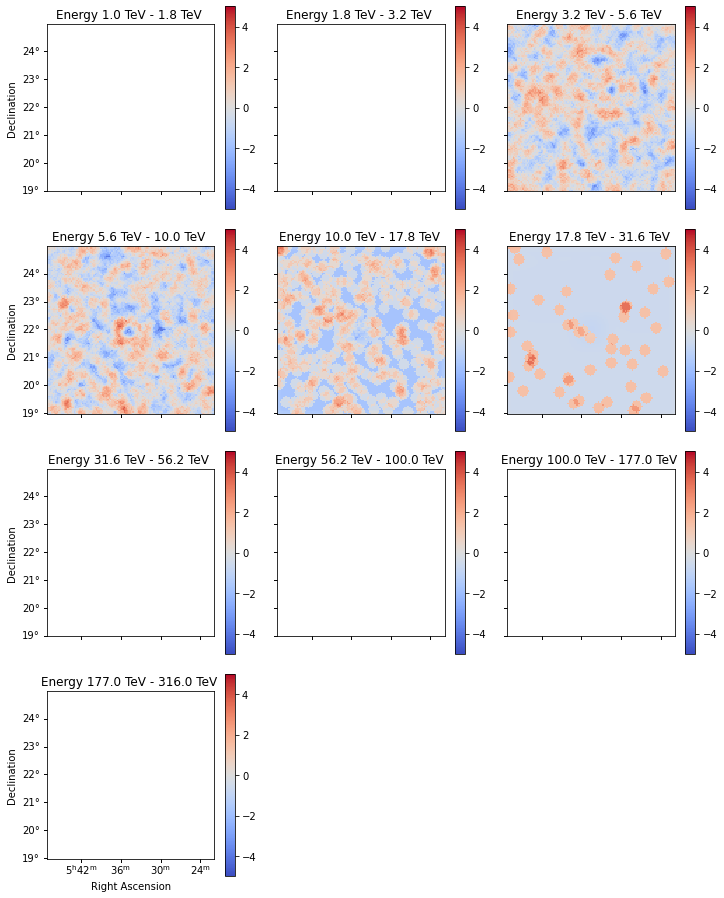

In [24]:
(datasets[4].mask*excess[4]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


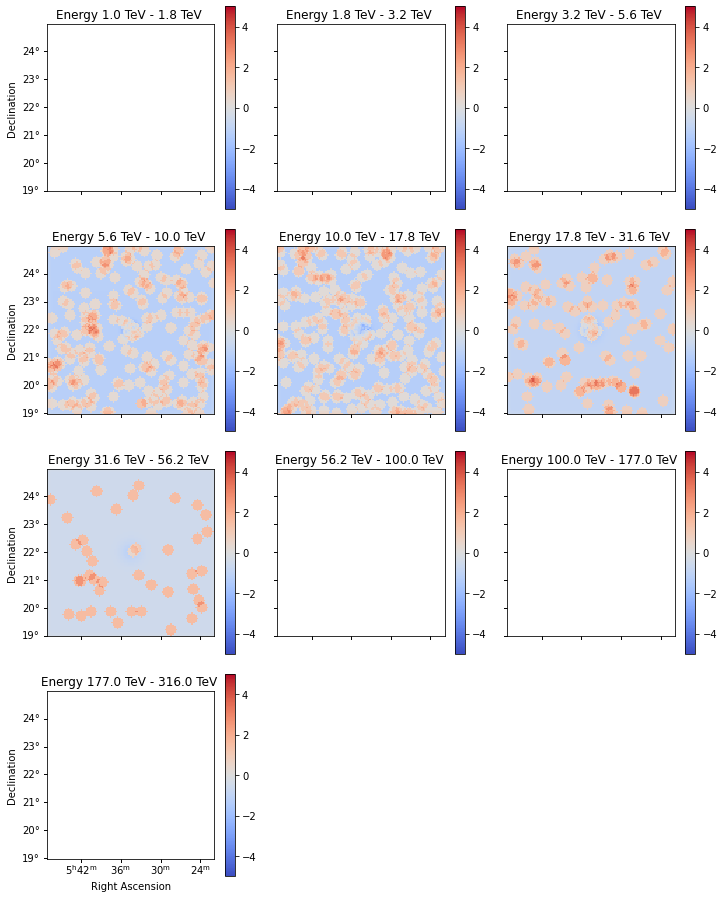

In [25]:
(datasets[6].mask*excess[6]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


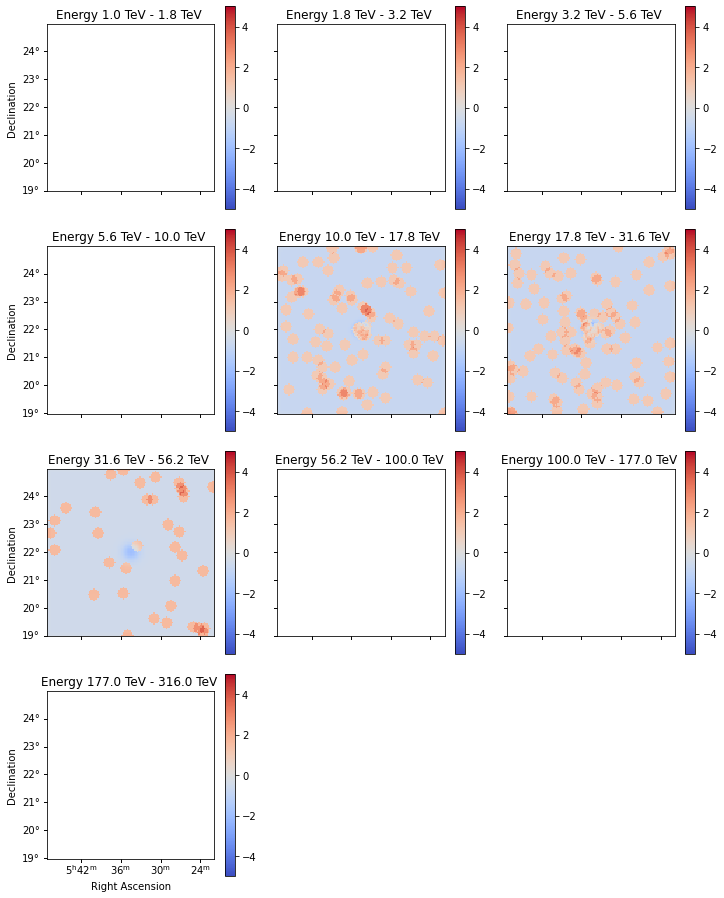

In [26]:
(datasets[7].mask*excess[7]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()

/home/hin/nieto/d1/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


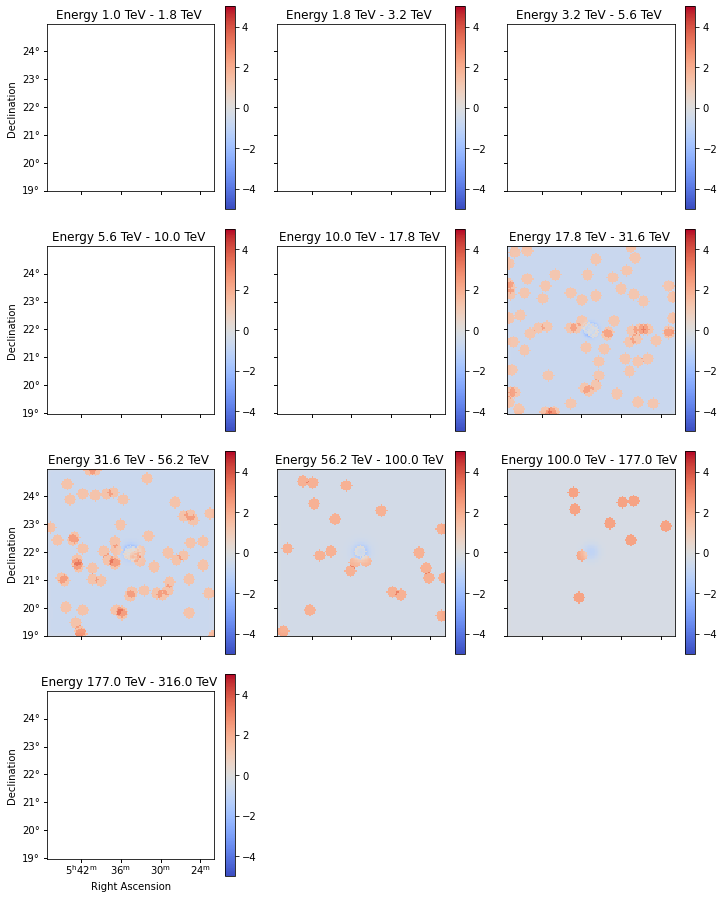

In [27]:
(datasets[8].mask*excess[8]['sqrt_ts']).plot_grid(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5)
plt.show()